# Pytorch MNIST Practice

### 載入需要的libarary

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Loading Traing data

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def cube_data(df):
    """Creates an n-d array from data frame"""
    if "label" in df.columns:
        imgs = df.drop("label", axis = 1).values # iloc: integer indexing, values: numpy ndarray
    else:
        imgs = df.values
    ntot = imgs.shape[0]         # number of rows

    imgs = imgs / 255
    
    # create a ntrain * 28 * 28 ndarray of training set
    cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")
    for i in range(0, ntot):
        cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)
    return cube

In [4]:
cube = cube_data(df)
ntot = cube.shape[0]

In [5]:
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

(array([27182695.,   399808.,   359330.,   306344.,   312800.,   363558.,
          317852.,   362706.,   427725.,  2895182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

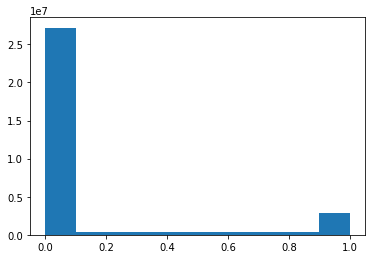

In [6]:
plt.hist(cube.flatten())

In [7]:
# Create a tensor containing the correct labels
labels = df['label'].values

In [8]:
# break data into training and validation sets
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [9]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23082, 1, 28, 28])
torch.Size([23082])


In [10]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)


  4   2   3   4   7   7   6   9   8   1   1   5   1   4   7   4


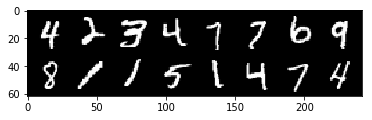

In [11]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%3s'%int(labels.numpy()[j]) for j in range(trainloader.batch_size)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
     
        
        self.conv2_drop = nn.Dropout2d()
       
        
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout(p=1)
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=120, bias=True)
  (fc1_drop): Dropout(p=1)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [13]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([120, 320])


In [14]:
optimizer = optim.Adam(net.parameters())

In [15]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss.data[0]))

In [16]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [17]:
for epoch in range(4): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/25200 (0%)]	Loss: 2.308596


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/25200 (25%)]	Loss: 2.300284
Train Epoch: 0 [12800/25200 (51%)]	Loss: 2.304189
Train Epoch: 0 [19200/25200 (76%)]	Loss: 2.293741

Test set: Average loss: 2.2995, Accuracy: 2573/23082 (11%)

Train Epoch: 1 [0/25200 (0%)]	Loss: 2.310591
Train Epoch: 1 [6400/25200 (25%)]	Loss: 2.298113
Train Epoch: 1 [12800/25200 (51%)]	Loss: 2.276151
Train Epoch: 1 [19200/25200 (76%)]	Loss: 2.283556

Test set: Average loss: 2.2995, Accuracy: 2573/23082 (11%)

Train Epoch: 2 [0/25200 (0%)]	Loss: 2.297205
Train Epoch: 2 [6400/25200 (25%)]	Loss: 2.293765
Train Epoch: 2 [12800/25200 (51%)]	Loss: 2.304888
Train Epoch: 2 [19200/25200 (76%)]	Loss: 2.304536

Test set: Average loss: 2.2995, Accuracy: 2574/23082 (11%)

Train Epoch: 3 [0/25200 (0%)]	Loss: 2.316420
Train Epoch: 3 [6400/25200 (25%)]	Loss: 2.300047
Train Epoch: 3 [12800/25200 (51%)]	Loss: 2.296242
Train Epoch: 3 [19200/25200 (76%)]	Loss: 2.315659

Test set: Average loss: 2.2995, Accuracy: 2573/23082 (11%)



In [18]:
test_df = pd.read_csv("data/test.csv")
test_cube = cube_data(test_df)
ntest = test_cube.shape[0]
test_cube = torch.FloatTensor(test_cube)

In [19]:
pred = net(Variable(test_cube))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [20]:
type(pred)

torch.autograd.variable.Variable

In [21]:
_, predicted = torch.max(pred, 1)

In [22]:
predicted

Variable containing:
 1
 1
 1
⋮ 
 1
 1
 1
[torch.LongTensor of size 28000]

In [23]:
d = {'ImageId' : pd.Series(np.arange(1, ntest + 1)), 
     'Label' : pd.Series(predicted.data.squeeze().numpy())}
test_df = pd.DataFrame(d)
test_df.to_csv("test-set-predictions.csv", index = False)